In [169]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5,amsgrad=False)
from time import time

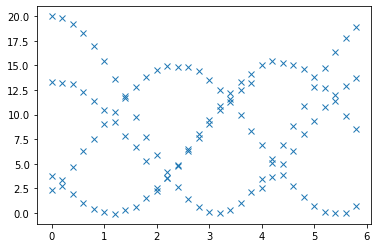

In [204]:
X = np.zeros([0,3])
Z = np.zeros([0,3])
Zlat = np.zeros([0,3])
y = np.zeros([0,1])
yreal = np.zeros([0,1])

#start & end positions, time start and end of each sample period, number of observations, number of inducing points in sensor and latent
samples = []
#path (pos,start time,obs)-(pos,end time)
samples.append({'ref':True,'path':[(0,0,30),(0,6,0)]})
samples.append({'ref':False,'path':[(0,0,10),(1,2,10),(0,4,10),(0,6,0)]})
samples.append({'ref':False,'path':[(1,0,30),(1,6)]})
#samples.append({'ref':False,'path':[(1,0,10),(2,2,10),(2,4,10)]})
samples.append({'ref':False,'path':[(2,0,30),(2,6)]})
S = len(samples) #number of sensors
sensorref = np.zeros([0,1])
for sensor,sample in enumerate(samples):
    Xnewt = np.zeros([0,1])
    Xnewp = np.zeros([0,1])
    for ps,pe in zip(sample['path'][:-1],sample['path'][1:]):
        Xnewt = np.r_[Xnewt,np.linspace(ps[1],pe[1],ps[2]+1)[:-1,None]]
        Xnewp = np.r_[Xnewp,np.full(ps[2],ps[0])[:,None]]
    
    sensorref = np.r_[sensorref,sample['ref']*np.ones([Xnewp.shape[0],1])]
    Xnew = np.c_[Xnewp,Xnewt,np.full(Xnewt.shape[0],sensor+1)]
    Znew = Xnew[::4,:]
    Znewlat = Xnew[::2,:]
    true = 10*(1+1*np.cos(Xnew[:,0:1]*2+Xnew[:,1:2]*1))
    if sample['ref']:
        ynew = true
    else:
        scaling = 1 + (-1**sensor + sensor*Xnew[:,1:2]/30 + np.sin(sensor*Xnew[:,1:2]/20)/30)/3
        ynew = true*(scaling)+np.random.randn(Xnew.shape[0],1)*0.1
    
    X = np.r_[X,Xnew]
    Z = np.r_[Z,Znew]
    Zlat = np.r_[Zlat,Znewlat]
    y = np.r_[y,ynew]
    yreal = np.r_[yreal,true]
latentX = X.copy()
latentX[:,-1]=0 #latent
X = np.r_[X,latentX]
Zlat[:,-1]=0
Z = np.r_[Z,Zlat]
plt.plot(X[0:int(len(X)/2),1],y,'x')

In [205]:
#location, time, sensor
from tabulate import tabulate
print(tabulate(Z[:,:],tablefmt="latex"))

\begin{tabular}{rrr}
\hline
 0 & 0   & 1 \\
 0 & 0.8 & 1 \\
 0 & 1.6 & 1 \\
 0 & 2.4 & 1 \\
 0 & 3.2 & 1 \\
 0 & 4   & 1 \\
 0 & 4.8 & 1 \\
 0 & 5.6 & 1 \\
 0 & 0   & 2 \\
 0 & 0.8 & 2 \\
 0 & 1.6 & 2 \\
 1 & 2.4 & 2 \\
 1 & 3.2 & 2 \\
 0 & 4   & 2 \\
 0 & 4.8 & 2 \\
 0 & 5.6 & 2 \\
 1 & 0   & 3 \\
 1 & 0.8 & 3 \\
 1 & 1.6 & 3 \\
 1 & 2.4 & 3 \\
 1 & 3.2 & 3 \\
 1 & 4   & 3 \\
 1 & 4.8 & 3 \\
 1 & 5.6 & 3 \\
 2 & 0   & 4 \\
 2 & 0.8 & 4 \\
 2 & 1.6 & 4 \\
 2 & 2.4 & 4 \\
 2 & 3.2 & 4 \\
 2 & 4   & 4 \\
 2 & 4.8 & 4 \\
 2 & 5.6 & 4 \\
 0 & 0   & 0 \\
 0 & 0.4 & 0 \\
 0 & 0.8 & 0 \\
 0 & 1.2 & 0 \\
 0 & 1.6 & 0 \\
 0 & 2   & 0 \\
 0 & 2.4 & 0 \\
 0 & 2.8 & 0 \\
 0 & 3.2 & 0 \\
 0 & 3.6 & 0 \\
 0 & 4   & 0 \\
 0 & 4.4 & 0 \\
 0 & 4.8 & 0 \\
 0 & 5.2 & 0 \\
 0 & 5.6 & 0 \\
 0 & 0   & 0 \\
 0 & 0.4 & 0 \\
 0 & 0.8 & 0 \\
 0 & 1.2 & 0 \\
 0 & 1.6 & 0 \\
 1 & 2   & 0 \\
 1 & 2.4 & 0 \\
 1 & 2.8 & 0 \\
 1 & 3.2 & 0 \\
 1 & 3.6 & 0 \\
 0 & 4   & 0 \\
 0 & 4.4 & 0 \\
 0 & 4.8 & 0 \\
 0 & 5.2 & 0

In [206]:
X = tf.Variable(X,dtype=tf.float32)
Z = np.unique(np.round(Z),axis=0)
Z = tf.Variable(Z,dtype=tf.float32)
y = tf.Variable(y,dtype=tf.float32)

In [207]:
def k(x1,x2):
    return np.exp(-(x1[1]-x2[1])**2/(2*5.0**2))

def klat(x1,x2):
    return np.exp(-(x1[1]-x2[1])**2/(2*1.0**2))+1

In [208]:
def K(X1,X2):
    try:
        X1 = X1.numpy()
        X2 = X2.numpy()
    except AttributeError:
        pass
    r = np.zeros([X1.shape[0],X2.shape[0]])
    for i1,x1 in enumerate(X1):
        for i2,x2 in enumerate(X2):
            if x1[2]==x2[2]==0: #if latent function...
                if x1[0]==x2[0]: #if in same place
                    r[i1,i2] = klat(x1,x2)
            if x1[2]==x2[2]!=0: #if scaling function
                r[i1,i2] = k(x1,x2)
    return tf.Variable(r,dtype=tf.float32)

(240, 0)

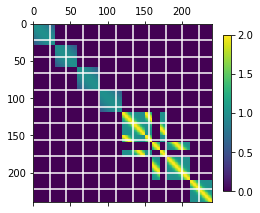

In [209]:
plt.matshow(K(X,X).numpy())
plt.colorbar(shrink=0.7)
plt.vlines(np.arange(0,X.shape[0],44.5/2),0,X.shape[0],'w')
plt.hlines(np.arange(0,X.shape[0],44.5/2),0,X.shape[0],'w')
plt.xlim([0,X.shape[0]])
plt.ylim([X.shape[0],0])
#plt.savefig('democov.pdf')

(50, 0)

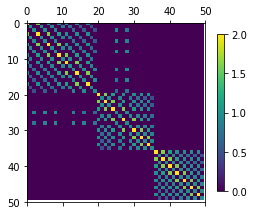

In [210]:
plt.matshow(K(Z,Z).numpy())
plt.colorbar(shrink=0.7)
#plt.vlines(np.arange(0,Z.shape[0],Z.shape[0]),0,Z.shape[0],'w')
#plt.hlines(np.arange(0,Z.shape[0],44.5/2),0,Z.shape[0],'w')
plt.xlim([0,Z.shape[0]])
plt.ylim([Z.shape[0],0])
#plt.savefig('democov.pdf')

In [211]:
Z

<tf.Variable 'Variable:0' shape=(50, 3) dtype=float32, numpy=
array([[0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 2.],
       [0., 1., 0.],
       [0., 1., 1.],
       [0., 1., 2.],
       [0., 2., 0.],
       [0., 2., 1.],
       [0., 2., 2.],
       [0., 3., 0.],
       [0., 3., 1.],
       [0., 4., 0.],
       [0., 4., 1.],
       [0., 4., 2.],
       [0., 5., 0.],
       [0., 5., 1.],
       [0., 5., 2.],
       [0., 6., 0.],
       [0., 6., 1.],
       [0., 6., 2.],
       [1., 0., 0.],
       [1., 0., 3.],
       [1., 1., 0.],
       [1., 1., 3.],
       [1., 2., 0.],
       [1., 2., 2.],
       [1., 2., 3.],
       [1., 3., 0.],
       [1., 3., 2.],
       [1., 3., 3.],
       [1., 4., 0.],
       [1., 4., 3.],
       [1., 5., 0.],
       [1., 5., 3.],
       [1., 6., 0.],
       [1., 6., 3.],
       [2., 0., 0.],
       [2., 0., 4.],
       [2., 1., 0.],
       [2., 1., 4.],
       [2., 2., 0.],
       [2., 2., 4.],
       [2., 3., 0.],
       [2., 3., 4.],
       [2., 4.

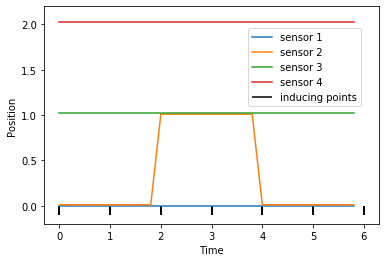

In [212]:
plt.figure(figsize=[6,4])
for s in range(0,S):
    sel = X.numpy()[:,2]==s+1
    plt.plot(X.numpy()[sel,1],s*0.01+X.numpy()[sel,0],'-',label="sensor %d" % int(s+1))

sel = X.numpy()[:,2]==0
#plt.plot(X.numpy()[sel,1],X.numpy()[sel,0],'xk')
plt.vlines(Z[:,1],-0.1,0,label='inducing points')
#plt.xlim([-1,12])
plt.ylabel('Position')
plt.xlabel('Time')
plt.ylim([-0.2,2.2])
plt.legend(loc=(0.61,0.54))
plt.savefig('routesofsensors.pdf')

In [213]:
#definition of q(u)
m = Z.shape[0]
mu = tf.Variable(1*tf.random.normal([m]))#, name='mu')
scale = tf.Variable(1*np.tril(1*np.random.randn(m, m)),dtype=tf.float32)#, name='scale')
###diag = tf.Variable(0*np.ones(m),dtype=tf.float32)

#parameters for p(u)
mu_u = tf.zeros([m],dtype=tf.float32)
cov_u = tf.Variable(K(Z,Z),dtype=tf.float32)

jitter = 1e-2
pu = tfd.MultivariateNormalFullCovariance(mu_u,cov_u+np.eye(cov_u.shape[0])*0.01)
Kzz = K(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*jitter
Kzzinv = np.linalg.inv(Kzz)
Kxx = K(X,X)
Kxz = K(X,Z)
Kzx = K(Z,X)
N = int(X.shape[0]/2)

In [214]:
def combine_sensor_latent(sens,lat,sensorref):
    return lat * sensorref[:,0] + (1-sensorref[:,0])*(lat/(1+sens/3)) # * sensorref
    #return lat * sensorref[:,0] + (1-sensorref[:,0])*lat/tf.exp(sens/10) # * sensorref

In [215]:
#def getcov(scale,diag):
#    return scale @ tf.transpose(scale) + tf.linalg.diag(tf.exp(diag))

#def getcov(scale,diag):
#    return scale @ tf.transpose(scale) + tf.linalg.diag(tf.exp(diag)) + tf.eye(scale.shape[0])*1e-5
    
def getcov(scale,diag):
    """diag not used!"""
    return tf.linalg.band_part(scale, -1, 0) @ tf.transpose(tf.linalg.band_part(scale, -1, 0))


In [227]:
import time
alltimes = []
old_elbo_loss = -np.inf
optimizer.learning_rate = 0.02
diag = None


#@tf.function
for it in range(10000):
    with tf.GradientTape() as tape:
        qu = tfd.MultivariateNormalTriL(mu,scale)
        
        qf_mu = Kxz @ Kzzinv @ mu[:,None]
        #qf_mu = Kxz @ tf.linalg.solve(Kzz , mu[:,None])
        #KzzinvKzx = tf.linalg.solve(Kzz, Kzx)
        #KzzinvCov = tf.linalg.solve(Kzz,getcov(scale,diag))
        #qf_cov = Kxx - Kxz @ KzzinvKzx + Kxz @ KzzinvCov @ KzzinvKzx
        qf_cov = Kxx - Kxz @ Kzzinv @ Kzx + Kxz @ Kzzinv @ getcov(scale,diag) @ Kzzinv @ Kzx
        
        #KzzinvKzx = tf.linalg.solve(Kzz, Kzx)
        #qf_cov = Kxx - Kxz @ KzzinvKzx + tf.transpose(KzzinvKzx) @ getcov(scale,diag) @ KzzinvKzx
        
        batched_mu = tf.transpose(tf.reshape(qf_mu,[2,N]))
        batched_cov = [[tf.linalg.diag_part(qf_cov[:N,:N]),tf.linalg.diag_part(qf_cov[N:,:N])],[tf.linalg.diag_part(qf_cov[:N,N:]),tf.linalg.diag_part(qf_cov[N:,N:])]]
        samps = tfd.MultivariateNormalFullCovariance(batched_mu,tf.transpose(batched_cov)+tf.eye(2)*jitter).sample(800)
        f = combine_sensor_latent(samps[:,:,0],samps[:,:,1],sensorref)
        lls = tfd.Normal(f,0.01).log_prob(y[:,0])
        ell = tf.math.reduce_sum(tfp.stats.percentile(tf.math.reduce_mean(tf.reshape(lls,[40,20,N]),axis=0),50.0,axis=0))
        elbo_loss = -ell+tfd.kl_divergence(qu,pu)
        
        gradients = tape.gradient(elbo_loss, [mu,scale])
        
       
        if np.isnan(gradients[0].numpy()[0]):
            print("yikes!")
            jitter*=10
            continue
        if jitter>0.001: #get it back to normal
            jitter = jitter/2
            
        #if it<200:
        #    optimizer.learning_rate = 0.1
        #    optimizer.apply_gradients(zip(gradients[0:1], [mu]))
        #else:
        #     optimizer.learning_rate = 0.01
        #optimizer.learning_rate = optimizer.learning_rate * 0.99
        optimizer.apply_gradients(zip(gradients, [mu, scale]))
    if it%50==0: print("%4d %5dk %0.0f %0.0f" % (it,elbo_loss.numpy()/1e3,gradients[0].numpy()[0],gradients[1].numpy()[0,0]))

   0  1087k 2854 11536
  50   878k 1779 10649
 100   850k 3864 10377
 150   725k 3021 10814
yikes!
 200   713k 3243 8395
 250   663k 1276 3634
 300   630k 168 5654
 350   611k 1719 6856
 400   587k 2805 9121
 450   542k 1923 5257
 500   525k 897 7443
 550   488k 1139 4393
 600   475k 481 3800
 650   466k 1564 3703
 700   447k 2011 3096
 750   433k 746 5904
 800   458k 81 1973
 850   383k 1628 3695
 900   368k 1758 964
 950   371k -516 4435
1000   339k 517 4184
1050   334k 1776 3226
1100   310k 360 2124
1150   302k 45 1391
1200   332k 313 1517
1250   272k 527 1278
1300   269k -131 797
1350   260k -1332 2369
1400   246k -283 882
1450   251k -206 956
1500   233k -164 1113
1550   228k -4 -47
1600   217k -220 1601
1650   208k 460 902
1700   210k -273 -857
yikes!
1750   207k -444 541
1800   201k -665 1181
1850   199k -308 884
1900   192k 629 -395
yikes!
1950   184k -145 1160
2000   189k -200 420
2050   180k -289 481
2100   176k -422 517
2150   168k 138 -776
2200   167k -255 -81
2250   164k -

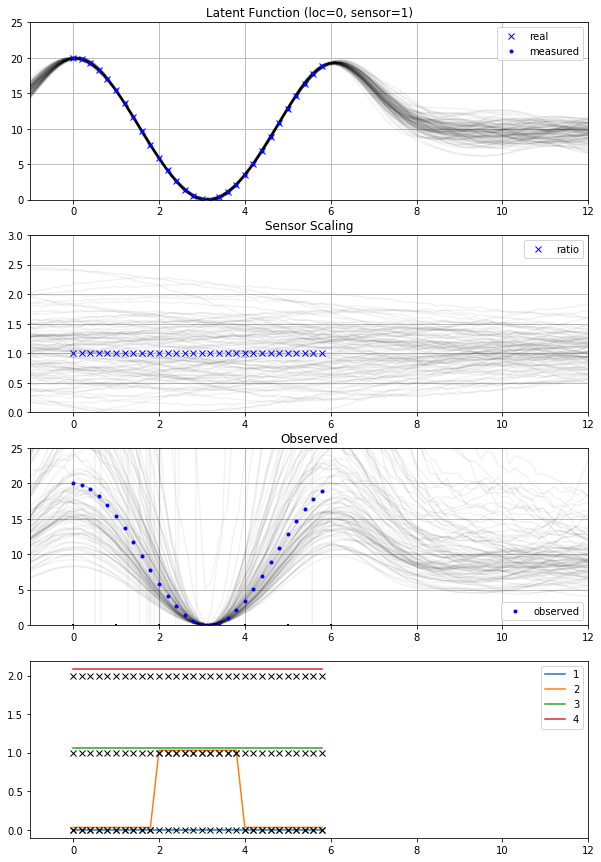

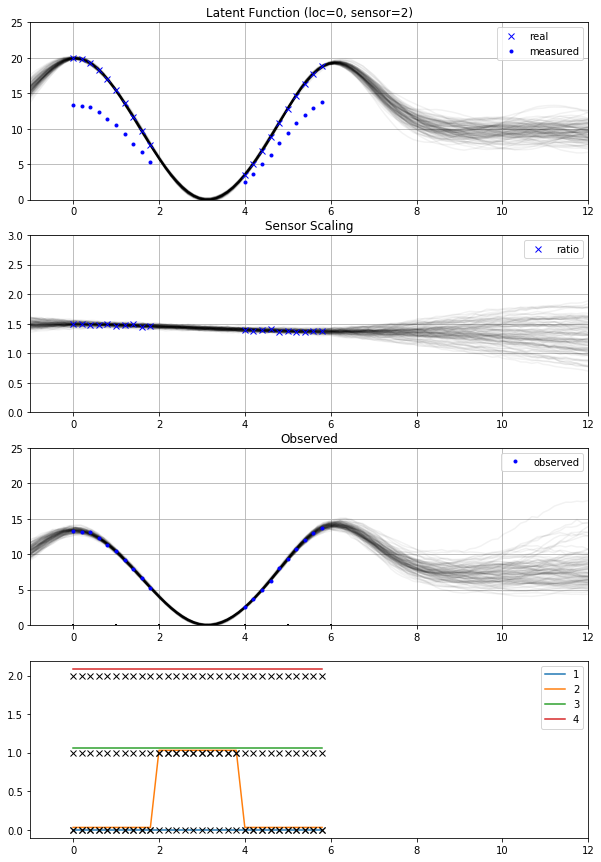

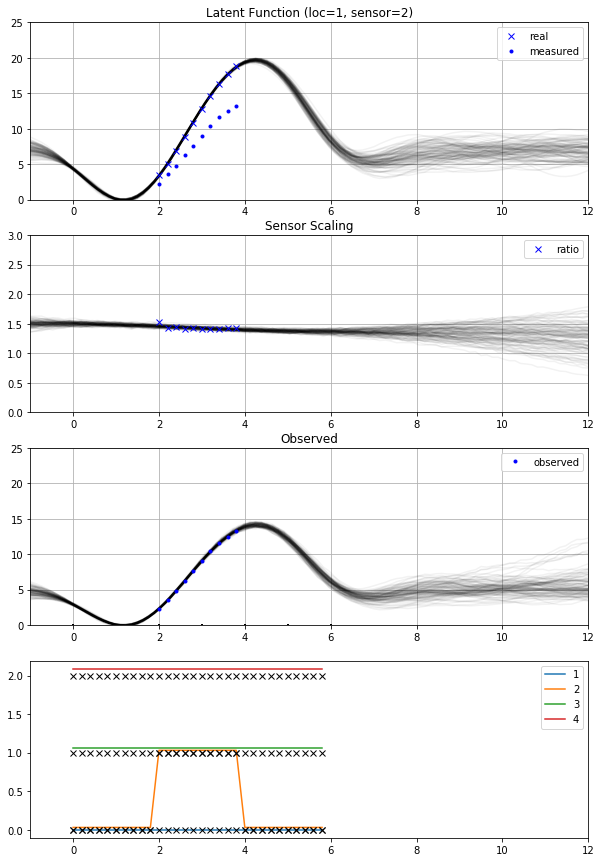

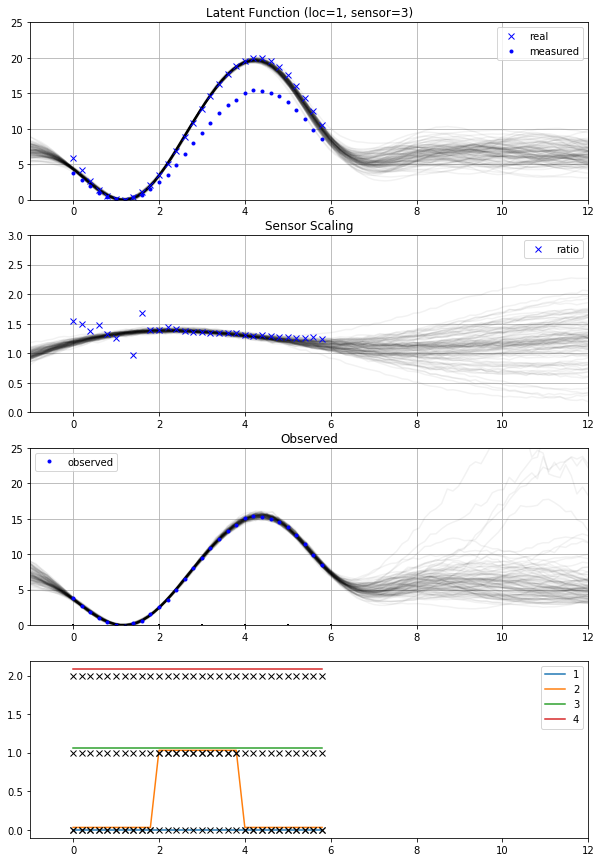

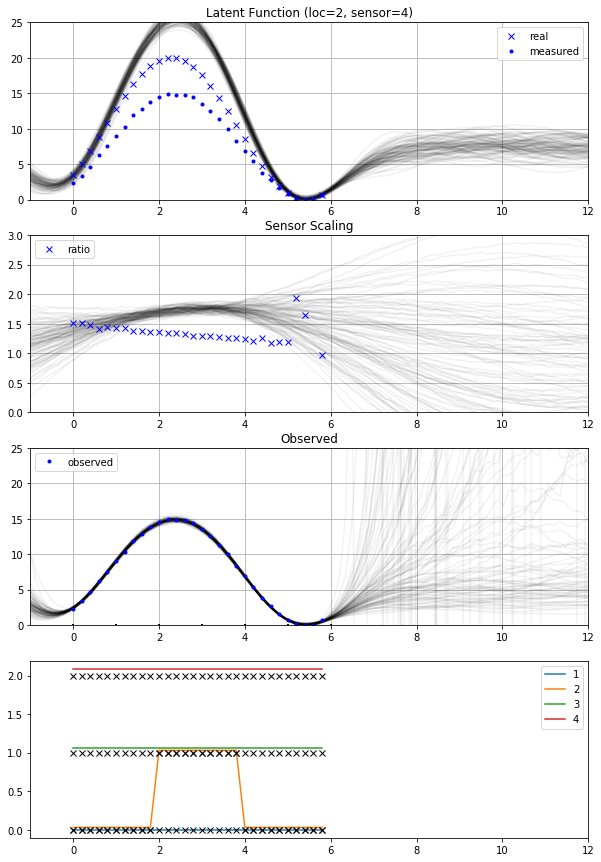

In [228]:
for testpos, testsensor in [[0,1],[0,2],[1,2],[1,3],[2,4]]:
    #testsensor = 4 #0=latent
    plotsensor = testsensor
    plt.figure(figsize=[10,15])
    #jitter = 1e-1
    #############################################################################
    Ntest = 100
    Xtest = np.linspace(-1,12,Ntest)[:,None]
    Xtest = np.r_[np.c_[testpos*np.ones(Xtest.shape[0]),Xtest,testsensor*np.ones(Xtest.shape[0])],np.c_[testpos*np.ones(Xtest.shape[0]),Xtest,np.zeros(Xtest.shape[0])]]
    Xtest = tf.Variable(Xtest,dtype=tf.float32)
    qf_mu = K(Xtest,Z) @ tf.linalg.solve(Kzz , mu[:,None])     
    KzzinvKzxtest = tf.linalg.solve(Kzz,K(Z,Xtest))
    qf_cov = K(Xtest,Xtest) - K(Xtest,Z) @ KzzinvKzxtest + tf.transpose(KzzinvKzxtest) @ getcov(scale,diag) @ KzzinvKzxtest
    qf = tfd.MultivariateNormalFullCovariance(qf_mu[:,0],qf_cov+np.eye(qf_cov.shape[0])*jitter)
    samps = qf.sample([100]).numpy()
    ############################################################################
    plt.subplot(4,1,1)
    plt.title('Latent Function (loc=%d, sensor=%d)' % (testpos,testsensor))
    plt.plot(Xtest[Ntest:,1],samps[:,Ntest:].T,'k-',alpha=0.05);
    plt.xlim([-1,12])
    tempX = X.numpy()[:N]
    keep = (tempX[:,0]==testpos) & (tempX[:,2]==plotsensor)
    plt.plot(tempX[keep,1],yreal[keep,0],'xb',label='real')
    plt.plot(tempX[keep,1],y.numpy()[keep,0],'.b',label='measured')
    plt.legend()
    plt.vlines(Z[:,1],-15,-14)
    plt.ylim([0,25])
    plt.grid()
    ############################################################################
    plt.subplot(4,1,2)
    plt.title('Sensor Scaling')
    scaling = 1/combine_sensor_latent(samps[:,:Ntest],np.ones(Ntest),np.zeros([Ntest,1])).T
    plt.plot(Xtest[Ntest:,1],scaling,'k-',alpha=0.05);
    plt.xlim([-1,12])
    tempX = X.numpy()[:N]
    keep = (tempX[:,0]==testpos) & (tempX[:,2]==plotsensor)
    plt.plot(tempX[keep,1],yreal[keep,0]/y.numpy()[keep,0],'xb',label='ratio')
    plt.legend()
    plt.vlines(Z[:,1],-15,-14)
    plt.ylim([0,3])
    plt.grid()
    ############################################################################
    plt.subplot(4,1,3)
    plt.title('Observed')
    plt.plot(Xtest[:,1][:Ntest],combine_sensor_latent(samps[:,:Ntest],samps[:,Ntest:],np.zeros([Ntest,1])).T,'k-',alpha=0.05);
    plt.xlim([-1,12])
    plt.vlines(Z[:,1],0,0.1)
    plt.ylim([0,25])
    plt.grid()
    plt.plot(tempX[keep,1],y.numpy()[keep,0],'.b',label='observed')
    plt.legend()
    ############################################################################
    plt.subplot(4,1,4)
    for s in range(0,S):
        sel = X.numpy()[:,2]==s+1
        plt.plot(X.numpy()[sel,1],s*0.03+X.numpy()[sel,0],'-',label=s+1)
    plt.legend()
    sel = X.numpy()[:,2]==0
    plt.plot(X.numpy()[sel,1],X.numpy()[sel,0],'xk')

    plt.xlim([-1,12])
    plt.savefig('pos%d_sensor%d' % (testpos, testsensor))